In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
path = "Gold_futures.csv"
gold_df=pd.read_csv(path)

In [3]:
gold_df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,4/01/2010,1117.699951,1122.300049,1097.099976,1117.699951,1117.699951,184.0


In [4]:
gold_df.dropna(inplace = True)

In [5]:
gold_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
df_g=gold_df.copy()

In [7]:
df_g["Date"]=pd.to_datetime(df_g["Date"],format='%d/%m/%Y')
df_g.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,1117.699951,184.0


In [8]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2518 entries, 0 to 3066
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2518 non-null   datetime64[ns]
 1   Open       2518 non-null   float64       
 2   High       2518 non-null   float64       
 3   Low        2518 non-null   float64       
 4   Close      2518 non-null   float64       
 5   Adj Close  2518 non-null   float64       
 6   Volume     2518 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 157.4 KB


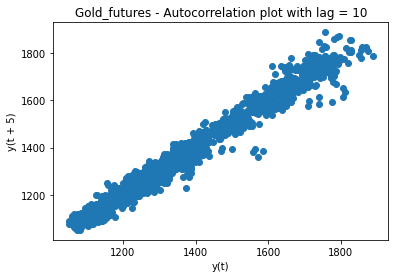

In [9]:
plt.figure()
lag_plot(df_g['Close'], lag=5)
plt.title('Gold_futures - Autocorrelation plot with lag = 10')
plt.show()

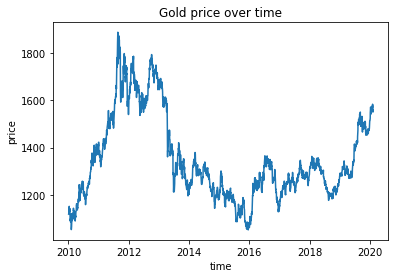

In [10]:
plt.plot(df_g["Date"], df_g["Close"])
# plt.xticks(np.arange(0,2485,100), df1['Date'][0:2485:100])
plt.title("Gold price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

We need adFuller test to determine the data is stationary or not.If the series is non-stationary using ADF,then d is required.

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
series=df_g['Close']
series

0       1117.699951
1       1118.099976
2       1135.900024
3       1133.099976
4       1138.199951
           ...     
3061    1583.500000
3062    1582.900024
3064    1577.199951
3065    1550.400024
3066    1557.800049
Name: Close, Length: 2518, dtype: float64

In [13]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window = 12, cutoff = 0.01):
#Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        pvalue = dftest[1]
        if pvalue < cutoff:
          print('p-value = %.4f. The series is likely stationary.' % pvalue)
        else:
          print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    print(dfoutput)

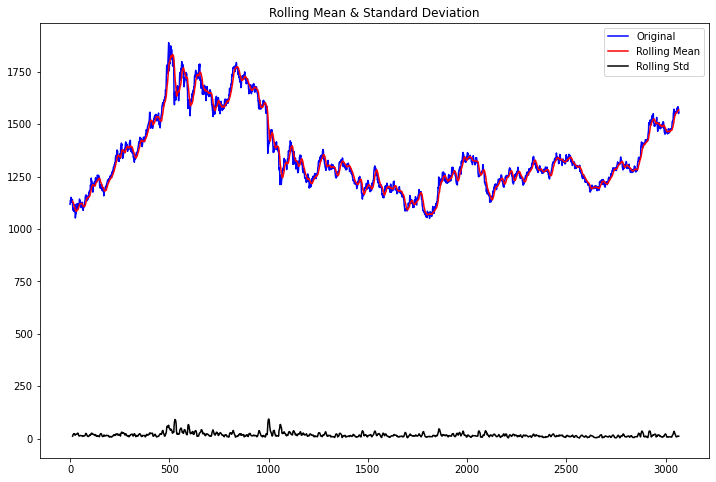

Results of Dickey-Fuller Test:
p-value = 0.3284. The series is likely non-stationary.
p-value = 0.3284. The series is likely non-stationary.
p-value = 0.3284. The series is likely non-stationary.
Test Statistic                   -1.907794
p-value                           0.328403
#Lags Used                       10.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64


In [14]:
test_stationarity(series)

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

import numpy as np

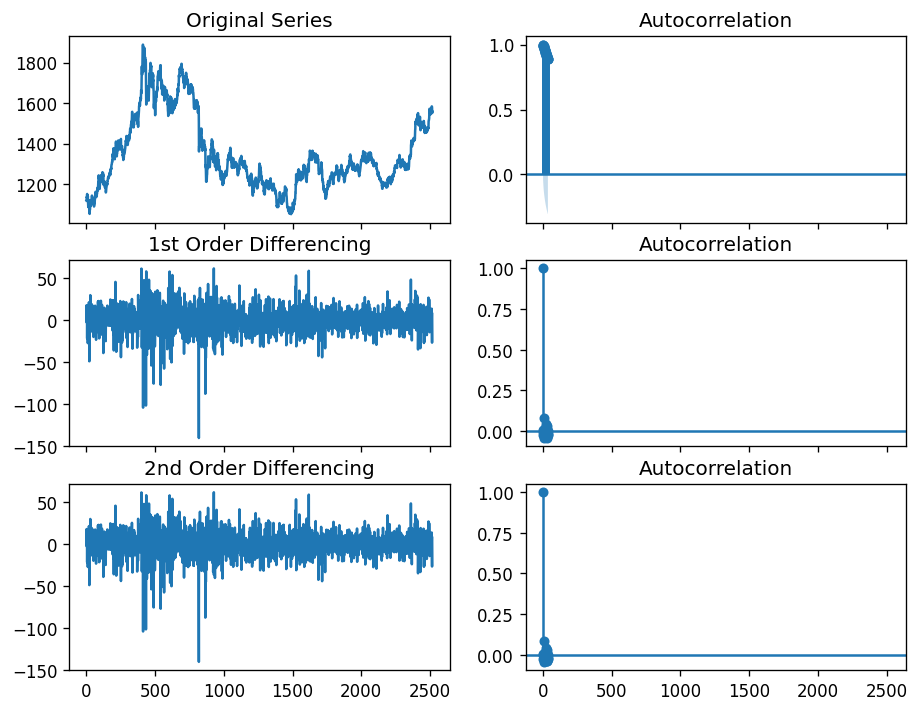

In [16]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_g['Close'].values); axes[0, 0].set_title('Original Series')
plot_acf(df_g['Close'].values, ax=axes[0, 1])


# 1st Differencing
axes[1, 0].plot(np.diff(df_g['Close'].values)); axes[1, 0].set_title('1st Order Differencing')
df_g=df_g.dropna()
plot_acf(np.diff(df_g['Close'].values), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(df_g['Close'].values)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(df_g['Close'].values), ax=axes[2, 1])

plt.show()

In [17]:
train_data, test_data = df_g[0:int(len(df_g)*0.8)], df_g[int(len(df_g)*0.8):]

In [18]:
training_data = train_data['Close'].values
test_data = test_data['Close'].values

history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
  
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

   
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 91.64696559082594


In [19]:
print(model_fit.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2516
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10203.524
Method:                       css-mle   S.D. of innovations             13.964
Date:                Sun, 21 Feb 2021   AIC                          20421.048
Time:                        16:31:16   BIC                          20461.861
Sample:                             1   HQIC                         20435.861
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1722      0.266      0.648      0.517      -0.349       0.693
ar.L1.D.y     -0.0268      0.020     -1.346      0.178      -0.066       0.012
ar.L2.D.y     -0.0051      0.020     -0.256      0.798      -0.044       0.034
ar

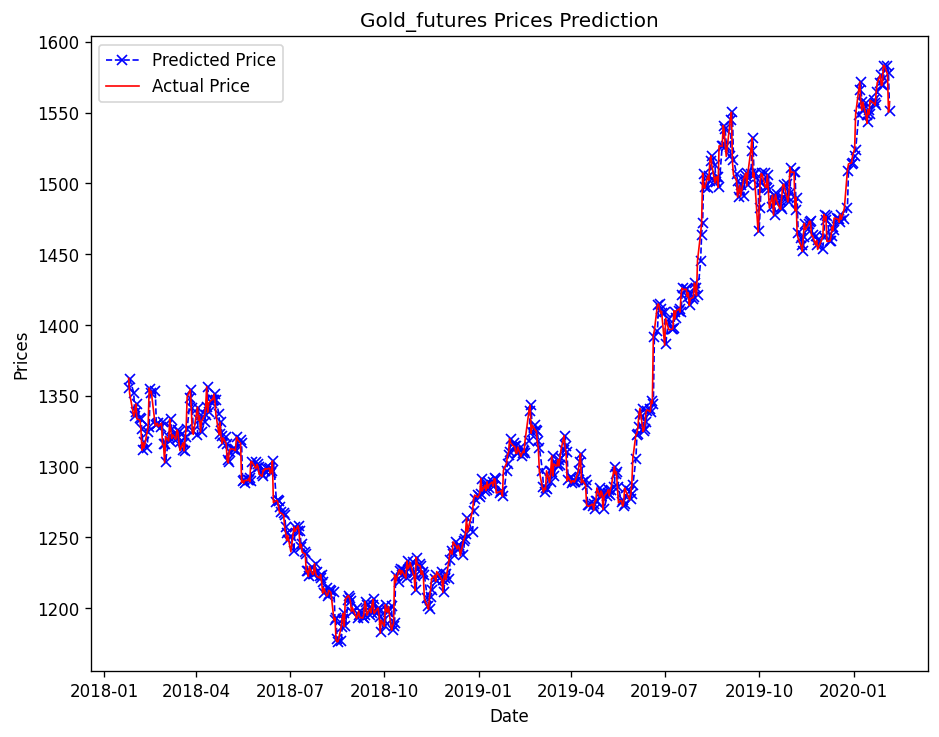

In [20]:
test_set_range = df_g[int(len(df_g)*0.8):].Date
plt.plot(test_set_range, model_predictions, color='blue', marker='x', linestyle='dashed',label='Predicted Price', lw=1)
plt.plot(test_set_range, test_data, color='red', label='Actual Price', lw=1)
plt.title('Gold_futures Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.legend()
plt.show()

In [21]:
date_df=pd.DataFrame(df_g[int(len(df_g)*0.8):].Date)
df_test = pd.DataFrame(data=test_data)
df_preds = pd.DataFrame(data=model_predictions)

display(date_df.head(3), df_test.head(3), df_preds.head(3))

,Date
2450,2018-01-25
2451,2018-01-26
2454,2018-01-30


,0
0,1362.400024
1,1351.599976
2,1335.400024


,0
0,1355.723605
1,1362.106639
2,1352.135022


In [22]:
date_df.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_preds.reset_index(drop=True, inplace=True)

df_preds = df_preds.shift(periods=+1)

# p = p.iloc[:-1]
# t = t.iloc[:-1]

frames=[date_df['Date'],df_test[0],df_preds[0]]
headers=['Date','test','preds']
graphdata_gold= pd.concat(frames, axis=1, keys=headers)

# graphdata = df_test.merge(df_preds, how='inner', suffixes=('_actual', '_prediction'))
graphdata_gold

,Date,test,preds
0,2018-01-25,1362.400024,NaN
1,2018-01-26,1351.599976,1355.723605
2,2018-01-30,1335.400024,1362.106639
3,2018-01-31,1339.000000,1352.135022
4,2018-02-01,1344.300049,1336.038731
...,...,...,...
499,2020-01-30,1583.500000,1569.613795
500,2020-01-31,1582.900024,1569.845059
501,2020-02-03,1577.199951,1583.163284
502,2020-02-04,1550.400024,1582.930128


In [23]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure([

    go.Scatter(
        name='Actual',
        x=graphdata_gold.Date,
        y=graphdata_gold['test'],
        mode='lines',
        marker=dict(color="#008080"),
        line=dict(width=1),
        showlegend=True
    ),
    go.Scatter(
        name='Prediction',
        x=graphdata_gold.Date,
        y=graphdata_gold['preds'],
        marker=dict(color="#FF8C00"),
        line=dict(width=1),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        showlegend=True
    )
])

fig.update_layout(
    yaxis_title='',
    title='',
    hovermode="x"
)

fig.show()
